# Inventory, ABC Analysis & Economic Impact

## Objective

This notebook closes the analytical loop by linking customer behavior (RFM segments) with inventory structure and revenue concentration. The goal is to identify structural dependencies between:

- Customer segments

- SKU criticality (ABC classes)

- Economic impact on total revenue

This analysis supports decisions in:

- Inventory prioritization

- Risk management

- Supply chain resilience

# 1. Environment Setup

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Project Paths & Data Loading

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

DATA_PATH = os.path.join(
    PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)

df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

if "TotalSum" not in df.columns:
    df["TotalSum"] = df["Quantity"] * df["Price"]

df["Year"] = df["InvoiceDate"].dt.year

# 3. Load RFM Segments

RFM segmentation results from the previous notebook are reconstructed to ensure reproducibility.

In [4]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("Customer ID")
      .agg({
          "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
          "Invoice": "nunique",
          "TotalSum": "sum"
      })
      .rename(columns={
          "InvoiceDate": "Recency",
          "Invoice": "Frequency",
          "TotalSum": "Monetary"
      })
)

rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)


def assign_segment(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions (VIP)"
    elif m >= 4 and r >= 3:
        return "Big Spenders"
    elif r <= 2:
        return "At Risk / Hibernating"
    else:
        return "Core Customers"

rfm["Segment"] = rfm.apply(assign_segment, axis=1)

# 4. ABC Inventory Classification

ABC analysis ranks SKUs by revenue contribution to identify critical inventory items.

In [5]:
sku_revenue = (
    df.groupby("Description", as_index=False)["TotalSum"]
      .sum()
      .sort_values("TotalSum", ascending=False)
)

sku_revenue["Revenue_Share"] = sku_revenue["TotalSum"].cumsum()
sku_revenue["Revenue_Share_Pct"] = (
    100 * sku_revenue["Revenue_Share"] / sku_revenue["TotalSum"].sum()
)

sku_revenue["ABC_Class"] = pd.cut(
    sku_revenue["Revenue_Share_Pct"],
    bins=[0, 80, 95, 100],
    labels=["A", "B", "C"]
)

sku_revenue.head()

,Description,TotalSum,Revenue_Share,Revenue_Share_Pct,ABC_Class
3753,REGENCY CAKESTAND 3 TIER,255191.14,255191.14,1.589972,A
5065,WHITE HANGING HEART T-LIGHT HOLDER,189637.64,444828.78,2.771513,A
3146,PARTY BUNTING,133332.99,578161.77,3.602246,A
2389,JUMBO BAG RED RETROSPOT,104791.01,682952.78,4.255148,A
3114,PAPER CHAIN KIT 50'S CHRISTMAS,82556.41,765509.19,4.769517,A


# 5. Pareto Curve Visualization

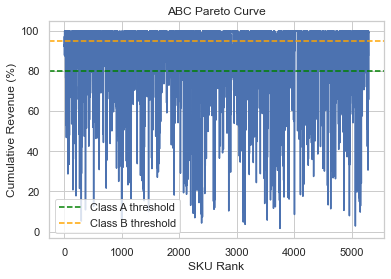

In [6]:
sns.lineplot(data=sku_revenue, x=sku_revenue.index, y="Revenue_Share_Pct")
plt.axhline(80, linestyle="--", color="green", label="Class A threshold")
plt.axhline(95, linestyle="--", color="orange", label="Class B threshold")
plt.ylabel("Cumulative Revenue (%)")
plt.xlabel("SKU Rank")
plt.title("ABC Pareto Curve")
plt.legend()
plt.show()

### Interpretation:

- Class A SKUs dominate revenue

- Small disruptions can have outsized impact

# 6. Linking Customers to Inventory

In [7]:
sku_class_map = sku_revenue.set_index("Description")["ABC_Class"]

df = df.assign(
    ABC_Class=df["Description"].map(sku_class_map)
)

df_enriched = df.merge(
    rfm[["Segment"]],
    left_on="Customer ID",
    right_index=True,
    how="left"
)

# 7. Inventory Dependency by Segment

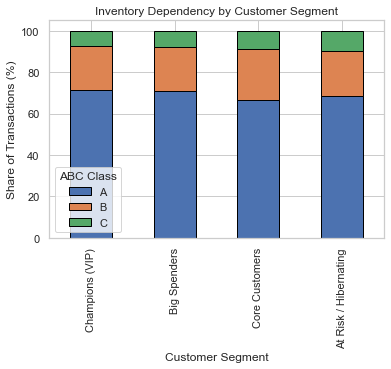

In [8]:
segment_inventory = (
    pd.crosstab(
        df_enriched["Segment"],
        df_enriched["ABC_Class"],
        normalize="index"
    ) * 100
)

segment_inventory

segment_inventory.loc[[
    "Champions (VIP)",
    "Big Spenders",
    "Core Customers",
    "At Risk / Hibernating"
]].plot(
    kind="bar",
    stacked=True,
    edgecolor="black"
)

plt.title("Inventory Dependency by Customer Segment")
plt.ylabel("Share of Transactions (%)")
plt.xlabel("Customer Segment")
plt.legend(title="ABC Class")
plt.show()

# 8. Economic Impact by Segment

In [11]:
segment_wealth = (
    rfm.groupby("Segment", as_index=False)["Monetary"]
       .sum()
       .assign(
           Revenue_%=lambda x: 100 * x["Monetary"] / x["Monetary"].sum()
       )
       .sort_values("Revenue_%", ascending=False)
)

segment_wealth

SyntaxError: invalid syntax (4139780944.py, line 5)

# 9. Key Business Insights

- Revenue is highly concentrated in a small subset of SKUs (Class A)

- Champions and Big Spenders depend disproportionately on Class A inventory

- Inventory disruptions in Class A SKUs directly threaten top-line revenue

- Core and At-Risk customers rely more on B/C inventory

# 10. Strategic Implications

- Prioritize Class A SKU availability for VIP segments

- Align safety stock policies with customer value

- Use segment-level ABC dependency for risk stress-testing

# 11. Final Note

This notebook completes a behavior → inventory → revenue analytical chain, enabling data-driven supply chain decisions grounded in customer economics.

